In [1]:
%load_ext tensorboard
import os, sys
import datetime
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
# dvc=device="cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


In [2]:
# Data sets for training W0 and training W1

class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        
        self.R = R
        self.T = T
        
    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.from_numpy(self.T[idx]), torch.from_numpy(self.R[idx])
    
class w1_dataset(Dataset):
    def __init__(self, T0, R0, T1, R1, theta0, theta1):
        super(w1_dataset, self).__init__()
        
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.T1 = T1
        self.theta0 = theta0
        self.theta1 = theta1
        self.inds = np.random.randint(0,len(R1),len(R0))
                
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 1:
            return torch.from_numpy(self.R1[self.inds[i]]), torch.from_numpy(self.T0[i]), torch.from_numpy(self.T1[self.inds[i]]), torch.from_numpy(self.theta0[i]), torch.from_numpy(self.theta1[self.inds[i]]), torch.tensor([label])
        else:
            return torch.from_numpy(self.R0[i]), torch.from_numpy(self.T0[i]), torch.from_numpy(self.T1[self.inds[i]]), torch.from_numpy(self.theta0[i]), torch.from_numpy(self.theta1[self.inds[i]]), torch.tensor([label])
        
class w1_dataset_2(Dataset):
    def __init__(self, T0, R0, T1, R1, theta0, theta1):
        super(w1_dataset_2, self).__init__()
        
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.T1 = T1
        self.theta0 = theta0
        self.theta1 = theta1
        self.inds = np.random.randint(0,len(R1),len(R0))
                
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 1:
            return self.R1[self.inds[i]], self.T1[self.inds[i]], torch.from_numpy(self.theta1[self.inds[i]]), torch.tensor([label])
        else:
            return self.R0[i], self.T0[i], torch.from_numpy(self.theta0[i]), torch.tensor([label])

In [3]:
# Loss function (NLL)

class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, normalize=False, device="cpu"):
        super(NLLLoss, self).__init__()
        self.normalize = normalize
        self.dvc = device
        if type(obs_data) == torch.Tensor:
            self.obs_data = obs_data.float().to(self.dvc)
        elif type(obs_data) == np.ndarray:
            self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        elif type(obs_data) == list:
            self.obs_data = torch.tensor(obs_data).float().to(self.dvc)
        if type(bins) == torch.Tensor:
            self.bins = bins.float().to(self.dvc)
        elif type(bins) == np.ndarray:
            self.bins = torch.from_numpy(bins).float().to(self.dvc)
        elif type(bins) == list:
            self.bins = torch.tensor(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights, theta):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R_i = torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
            h_R = torch.cat((h_R, h_R_i)) if h_R != None else h_R_i
        if self.normalize: h_R = h_R * self.y_obs_data / h_R.sum()
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum(), log_gauss))
        return nll

class NLLLoss_2D(nn.Module):

    def __init__(self, obs_data, bins1, bins2, device="cpu"):
        super(NLLLoss_2D, self).__init__()
        self.dvc = device
        self.h_obs_data = np.array([[((np.digitize(obs_data[:,0], bins1)==i) * (np.digitize(obs_data[:,1], bins2)==j)).sum() for j in range(1, len(bins2))] for i in range(1, len(bins1))])
        if type(bins1) == torch.Tensor:
            self.bins1 = bins.float().to(self.dvc)
        elif type(bins1) == np.ndarray:
            self.bins1 = torch.from_numpy(bins1).float().to(self.dvc)
        elif type(bins1) == list:
            self.bins1 = torch.tensor(bins1).float().to(self.dvc)
        if type(bins2) == torch.Tensor:
            self.bins2 = bins2.float().to(self.dvc)
        elif type(bins2) == np.ndarray:
            self.bins2 = torch.from_numpy(bins2).float().to(self.dvc)
        elif type(bins2) == list:
            self.bins2 = torch.tensor(bins2).float().to(self.dvc)
        self.y_obs_data = len(obs_data)
        
    def forward(self, R, weights, theta):
        nll = 0
        for i in range(1, len(self.bins1)):
            for j in range(1, len(self.bins2)):
                h_R_ij = torch.matmul(torch.transpose((torch.bucketize(R, self.bins1)==i).double()*weights.reshape(-1,1), 0, 1), (torch.bucketize(R, self.bins2)==j).double())[0,1]#.reshape(1,1)
                if h_R_ij > 0:
                    nll += self.h_obs_data[i-1, j-1]*torch.log(h_R_ij) - h_R_ij
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(nll, log_gauss))
        return nll
    
    
def roc_auc(input, target, weight=None):
    fpr, tpr, _ = roc_curve(target, input, sample_weight=weight)
    tpr, fpr = np.array(list(zip(*sorted(zip(tpr, fpr)))))
    return 1 - auc(tpr, fpr)

def EventWeightedBinaryCrossEntropy(input, target, weight=None):
    p = torch.ones_like(input)
    log_sig_x = torch.log(input)
    sub_1_x = torch.sub(p, input)
    sub_1_y = torch.sub(p, target)
    log_1_x = torch.log(sub_1_x)
    output = torch.neg(
        torch.add(
            torch.mul(target, log_sig_x),
            torch.mul(sub_1_y, log_1_x),
        ),
    )

    if weight != None:
        output = torch.mul(weight, output)
        return torch.div(output.sum(), weight.sum())
    else:
        return torch.div(output.sum(), len(target))

class EventWeightedBCE(nn.Module):
    """
    Cross entropy with instance-wise weights. Leave `aggregate` to None to obtain a loss
    vector of shape (batch_size,).
    """
    def __init__(self):
        super(EventWeightedBCE, self).__init__()

    def forward(self, input, target, weight=None):
        return EventWeightedBinaryCrossEntropy(input, target, weight)
    
def ExpEventWeightedBinaryCrossEntropy(input, target, weight=None):
    p = torch.ones_like(input)
    log_sig_x = torch.log(input)
    sub_1_x = torch.sub(p, input)
    sub_1_y = torch.sub(p, target)
    log_1_x = torch.log(sub_1_x)
    output = torch.neg(
        torch.add(
            torch.mul(target, log_sig_x),
            torch.mul(sub_1_y, log_1_x),
        ),
    )

    if weight != None:
        output = torch.mul(weight, output)
        return torch.exp(torch.div(output.sum(), weight.sum()))
    else:
        return torch.exp(torch.div(output.sum(), len(target)))

class ExpEventWeightedBCE(nn.Module):
    """
    Cross entropy with instance-wise weights. Leave `aggregate` to None to obtain a loss
    vector of shape (batch_size,).
    """
    def __init__(self):
        super(ExpEventWeightedBCE, self).__init__()

    def forward(self, input, target, weight=None):
        return ExpEventWeightedBinaryCrossEntropy(input, target, weight)

In [4]:
# All the networks (W0, W1 and theta)

class w0_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=False, std_params=None):
        super(w0_network, self).__init__()
            
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(1 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        if self.std_params: T = (T-self.std_params[0])/self.std_params[1]
        logit = self.linear_relu_stack(T)
        if self.sigmoid:
            return logit / (1 - logit)
        else:
            return torch.exp(logit)
        
class w0_dummy(nn.Module):
    def __init__(self):
        super(w0_dummy, self).__init__()
        
    def forward(self, T):
        return 1
    
class w1_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None, n_inputs=6):
        super(w1_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        self.n_inputs = n_inputs
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(self.n_inputs if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        # self.loss_fn = nn.BCELoss()
        
    def forward(self, T0, R, theta1, theta0, T1):
        T0 = (T0-self.std_params[0])/self.std_params[1]
        T1 = (T1-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
#         x = torch.cat([R, T0, theta0, T1, theta1], dim=1)
        x = torch.cat([R, theta0, theta1], dim=1)
#         x = torch.cat([R, T0, T1], dim=1)
#         x = R
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return torch.cat([(logit) / (1 - logit + 0.00000000000001), logit], dim=1)
        else:
            return torch.cat([torch.exp(logit), nn.Sigmoid(logit)], dim=1)
        
class w1_dummy(nn.Module):
    def __init__(self):
        super(w1_dummy, self).__init__()
        
    def forward(self, T0, R, theta1, theta0, T1):
        return 1
    
class w1T_network(w1_network):
    def __init__(self, n_inputs=2, *args, **kwargs):
        super(w1T_network, self).__init__(n_inputs=n_inputs, *args, **kwargs)
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        x = torch.cat([T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return torch.cat([(logit) / (1 - logit + 0.00000000000001), logit], dim=1)
        else:
            return torch.cat([torch.exp(logit), nn.Sigmoid(logit)], dim=1)
    
class w1RT_network(w1_network):
    def __init__(self, n_inputs=4, *args, **kwargs):
        super(w1RT_network, self).__init__(n_inputs=n_inputs, *args, **kwargs)
        
    def forward(self, T, R, theta):
        T = (T-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T, theta], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return torch.cat([(logit) / (1 - logit + 0.00000000000001), logit], dim=1)
        else:
            return torch.cat([torch.exp(logit), nn.Sigmoid(logit)], dim=1)
class theta_module(nn.Module):
    def __init__(self, init_value=0.):
        super(theta_module, self).__init__()
        self.theta = nn.Parameter(torch.ones(1) * init_value)
        
    def forward(self):
        return self.theta

In [5]:
# training and testing utilities
            
def test_w1_2(test_dataloader, model_w1RT, model_w1T, theta):
       
    # now evaluate performance at the epoch end
    model_w1RT.eval()
    model_w1T.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1RT(T, R, ones*theta)[:,0].unsqueeze(dim=1)/model_w1T(T, R, ones*theta)[:,0].unsqueeze(dim=1)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

class w1_trainer:
    
    def __init__(self, train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model_w1 = model_w1
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.patience = patience
        
        print("===================== Model W1 =====================")
        print(model_w1)

        self.best_state = self.model_w1.state_dict()
        self.best_epoch = None
        self.best_val_loss = None
        self.i_try = 0
        self.epoch = 0
        self.size = len(train_dataloader.dataset)
        
    def backpropagation(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def train_step(self):
        self.model_w1.train()
        for batch, (R, T0, T1, theta0, theta1, label) in enumerate(self.train_dataloader):
            R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

            W = self.model_w1(T0, R, theta1, theta0, T1)
#             logit = W/(W + 1)
            loss = self.loss_fn(W[:, 1].unsqueeze(dim=1), label.double())

            # Backpropagation
            self.backpropagation(loss)

            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w1.eval()
        Ws, logits, labels = None, None, None
        with torch.no_grad():
            for batch, (R, T0, T1, theta0, theta1, label) in enumerate(data_loader):
                R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

                W = self.model_w1(T0, R, theta1, theta0, T1)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
#             logits = Ws/(Ws + 1)
            loss = self.loss_fn(Ws[:, 1].unsqueeze(dim=1), labels.double())
            auc = roc_auc(Ws[:, 1].cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
        return loss, auc
    
    def fit(self, n_epoch=None):   
        max_epoch = (self.epoch+n_epoch+1) if n_epoch else self.max_epoch
        
        for epoch in range(self.epoch+1, max_epoch):
            self.epoch = epoch
            
            # train
            self.train_step()

            # evaluate loss for traing set
            train_loss, train_auc = self.eval_step(self.train_dataloader)

            # evaluate loss for validation set
            val_loss, val_auc = self.eval_step(self.val_dataloader)

            print("\r" + " "*(50), end="")
            print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f} Train_auc: {train_auc:>7f}] [Val_loss: {val_loss:>7f} Val_auc: {val_auc:>7f}]")

            if self.best_val_loss == None or val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_state = copy.deepcopy(self.model_w1.state_dict())
                self.best_epoch = epoch
                self.i_try = 0
            elif self.i_try < self.patience:
                self.i_try += 1
            else:
                print(f"Early stopping! Restore state at epoch {self.best_epoch}.")
                print(f"[Best_val_loss: {self.best_val_loss:>7f}]")
                self.model_w1.load_state_dict(self.best_state)
                break
                
class w1_trainer_2(w1_trainer):
    def __init__(self, *args, **kwargs):
        super(w1_trainer_2, self).__init__(*args, **kwargs)
        
    def train_step(self):
        self.model_w1.train()
        for batch, (R, T, theta, label) in enumerate(self.train_dataloader):
            R, T, theta, label = R.to(dvc), T.to(dvc), theta.to(dvc), label.to(dvc)

            W = self.model_w1(T, R, theta)
#             logit = W/(W + 1)
            loss = self.loss_fn(W[:, 1].unsqueeze(dim=1), label.double())

            # Backpropagation
            self.backpropagation(loss)

            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {self.epoch:>3d}] [{current:>5d}/{self.size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
    def eval_step(self, data_loader):
        self.model_w1.eval()
        Ws, logits, labels = None, None, None
        with torch.no_grad():
            for batch, (R, T, theta, label) in enumerate(data_loader):
                R, T, theta, label = R.to(dvc), T.to(dvc), theta.to(dvc), label.to(dvc)

                W = self.model_w1(T, R, theta)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
#             logits = Ws/(Ws + 1)
            loss = self.loss_fn(Ws[:, 1].unsqueeze(dim=1), labels.double())
            auc = roc_auc(Ws[:, 1].cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
        return loss, auc
            
def test_w1p(test_dataloader, model_w1):
    
    model_w1.eval()
    Ws, labels = None, None
    Rs, T0s, T1s, theta0s, theta1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (R, T0, T1, theta0, theta1, label) in enumerate(test_dataloader):
            R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

            W = model_w1(T0, R, theta1, theta0, T1)
            Ws = torch.cat([Ws, W]) if Ws is not None else W
            labels = torch.cat([labels, label]) if labels is not None else label
            
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            T0s = torch.cat([T0s, T0]) if T0s is not None else T0
            T1s = torch.cat([T1s, T1]) if T1s is not None else T1
            theta0s = torch.cat([theta0s, theta0]) if theta0s is not None else theta0
            theta1s = torch.cat([theta1s, theta1]) if theta1s is not None else theta1
            
        logits = Ws/(Ws + 1)
        test_loss = loss_fn(logits, labels.double())
        test_auc = roc_auc(logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1))
    print("\r" + f"[Test_loss: {test_loss:>7f} Test_auc: {test_auc:>7f}]")
    return logits.cpu().numpy().reshape(-1), labels.cpu().numpy().reshape(-1), Rs.cpu().numpy(), T0s.cpu().numpy(), T1s.cpu().numpy(), theta0s.cpu().numpy(), theta1s.cpu().numpy()
            
def test_w1(test_dataloader, model_w1, theta):
       
    # now evaluate performance at the epoch end
    model_w1.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = torch.ones(len(R), 1).to(dvc)

            # Compute weights
            W1 = model_w1(T, R, ones*theta, ones*theta, T)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

def train_w0(train_dataloader, val_dataloader, model_w0, model_w1, model_theta, loss_fn, optimizer, optimizer1=None, max_epoch=1000, patience=10):
    
    print("===================== Model W0 =====================")
    print(model_w0)
    print("===================== Model W1 =====================")
    print(model_w1)
    print(f"Initial theta: {model_theta().item()}")
    
    model_w1.eval()
    
    best_state = model_w0.state_dict()
    best_theta = model_theta.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    print("====================================================")
    print(" Start optimizing the W0 model and theta")
    print("====================================================")
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w0.train()
        model_theta.train()
        for batch, (T, R) in enumerate(train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = (R+0.0000000001)/(R+0.0000000001)

            # Compute weights
            theta = model_theta()[0]
            W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
            loss = loss_fn(R, W, theta)

            # Backpropagation
            optimizer.zero_grad()
            if optimizer1 != None:
                optimizer1.zero_grad()
            loss.backward()
            optimizer.step()
            if optimizer1 != None:
                optimizer1.step()
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}] [Theta: {model_theta().item()}]", end="")
        
        # now evaluate performance at the epoch end
        model_w0.eval()
        model_theta.eval()
        
        # evaluate loss for traing set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(train_dataloader):
                T, R = T.to(dvc), R.to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            train_loss = loss_fn(Rs, Ws, theta)
            
        # evaluate loss for validation set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(val_dataloader):
                T, R = T.to(dvc), R.to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            val_loss = loss_fn(Rs, Ws, theta)
        
        print("\r" + " "*(80), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {model_theta().item()}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w0.state_dict())
            best_theta = copy.deepcopy(model_theta.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            print(f"FittedM theta: {theta_model().item()}")
            model_w0.load_state_dict(best_state)
            model_theta.load_state_dict(best_theta)
            break
        
        
def test_w0(test_dataloader, model_w0, model_w1, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = (R+0.0000000001)/(R+0.0000000001)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
#             W0 = torch.tensor(1.0)
            W1 = model_w1(T, R, ones*theta, ones*theta, T)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

In [6]:
# Visualization

class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", ratio_label="Data/Pred.", header="Gaussian Example", density=True, save_name=None, legend_corner="upper left"):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.legend_corner = legend_corner
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel(ratio_label,fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        if os.path.isfile(f"plot/{self.save_name}.pdf"):
            i = 0
            while os.path.isfile(f"plot/{self.save_name}_{i}.pdf"):
                i += 1
            self.save_name = f"{self.save_name}_{i}"
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc=self.legend_corner)
        self.save()
        plt.show()
        plt.clf()

['T_Ptyy', 'R_Ptyy', 'R_myy', 'Theta']


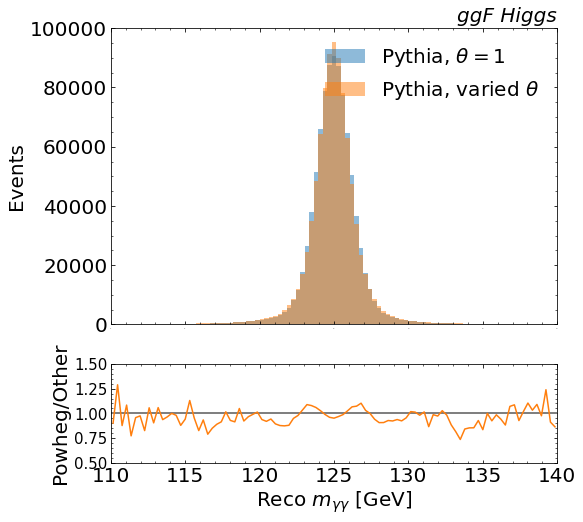

<Figure size 432x288 with 0 Axes>

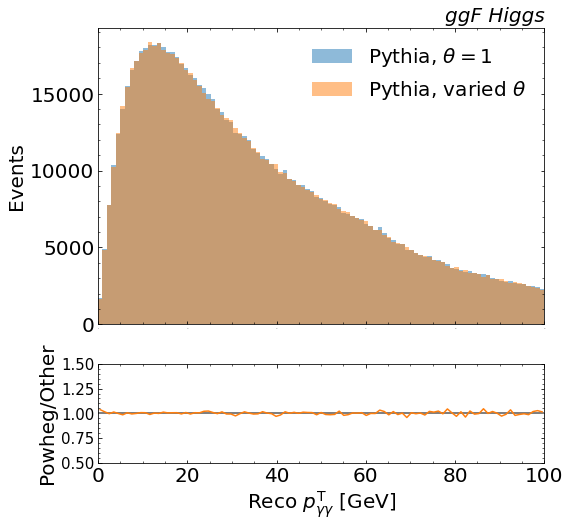

<Figure size 432x288 with 0 Axes>

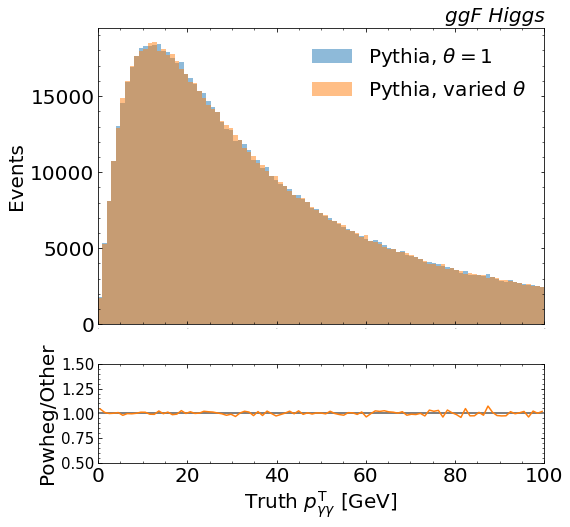

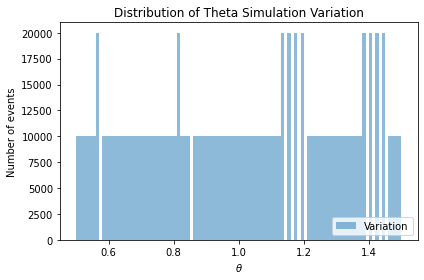

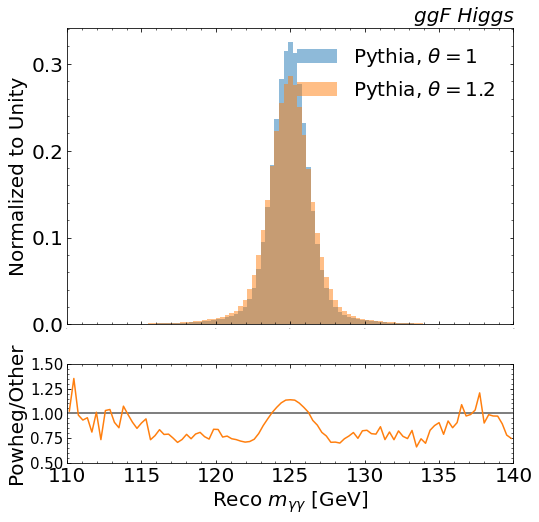

<Figure size 432x288 with 0 Axes>

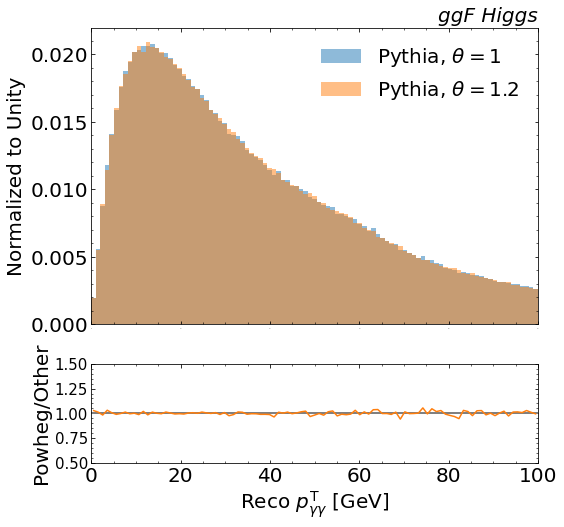

<Figure size 432x288 with 0 Axes>

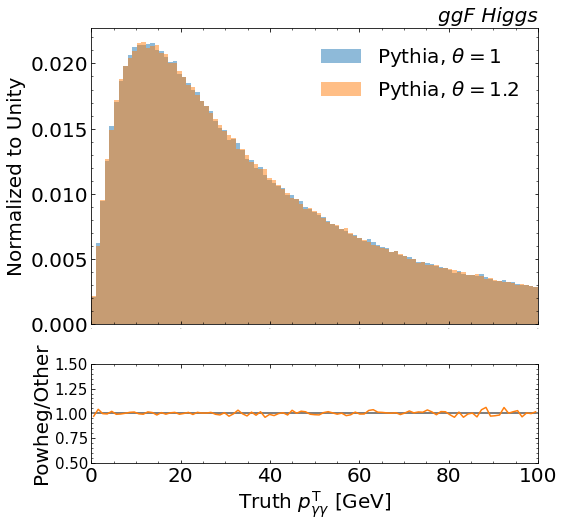

<Figure size 432x288 with 0 Axes>

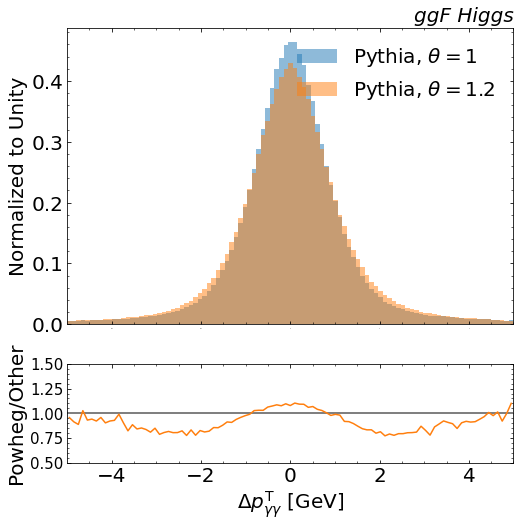

<Figure size 432x288 with 0 Axes>

In [7]:
pythia_0 = np.load("data/processed_pythia_1.0_1000000.npz")
pythia_1 = np.load("data/processed_pythia_1.2_1000000.npz")
pythia_syst = np.load("data/processed_pythia_syst_1000000.npz")

print(list(pythia_syst.keys()))

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["R_myy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_syst["R_myy"].astype(float), label=r"Pythia, varied $\theta$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["R_Ptyy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_syst["R_Ptyy"].astype(float), label=r"Pythia, varied $\theta$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["T_Ptyy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_syst["T_Ptyy"].astype(float), label=r"Pythia, varied $\theta$", alpha=0.5, color='tab:orange')
cpwr.show()

plt.hist(pythia_syst["Theta"], range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["R_myy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_1["R_myy"].astype(float), label=r"Pythia, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["R_Ptyy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_1["R_Ptyy"].astype(float), label=r"Pythia, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["T_Ptyy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_1["T_Ptyy"].astype(float), label=r"Pythia, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-5, 5, 100, xlabel=r'$\Delta p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=True, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(pythia_0["R_Ptyy"].astype(float)-pythia_0["T_Ptyy"].astype(float), label=r"Pythia, $\theta = 1$", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia_1["R_Ptyy"].astype(float)-pythia_1["T_Ptyy"].astype(float), label=r"Pythia, $\theta = 1.2$", alpha=0.5, color='tab:orange')
cpwr.show()

In [8]:
# Convert data into W1 dataset, data loaders and create loss function

T_sim_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_sim_1 = pythia_syst["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_sim_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_sim_1 = pythia_syst["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_sim_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_sim_1 = pythia_syst["R_myy"].astype(float).reshape(-1, 1)

# T_sim_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
# T_sim_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

# R_Ptyy_sim_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
# R_Ptyy_sim_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

# R_myy_sim_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
# R_myy_sim_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

Delta_theta = 0.5
# theta_sim_0 = ((np.random.uniform(0.5, 1.59, 1000000)-1.0)/Delta_theta).reshape(-1, 1) # continuous
theta_sim_0 = ((np.array(list(np.linspace(0.5,1.49,100))*10000)-1.0)/Delta_theta).reshape(-1, 1) # discrete
# theta_sim_0 = ((pythia_syst["Theta"].astype(float)-1.0)/Delta_theta).reshape(-1, 1)
np.random.shuffle(theta_sim_0)
theta_sim_1 = ((pythia_syst["Theta"].astype(float)-1.0)/Delta_theta).reshape(-1, 1)
theta_test = (1.2-1.0)/Delta_theta

# R_sim_0 = R_myy_sim_0
# R_sim_1 = R_myy_sim_1
# R_sim_0 = R_Ptyy_sim_0
# R_sim_1 = R_Ptyy_sim_1
R_sim_0 = np.concatenate([R_Ptyy_sim_0, R_myy_sim_0], axis=1)
R_sim_1 = np.concatenate([R_Ptyy_sim_1, R_myy_sim_1], axis=1)

print(T_sim_0.shape, T_sim_1.shape, R_sim_0.shape, R_sim_1.shape, theta_sim_0.shape, theta_sim_1.shape)

w1_ds = w1_dataset(T_sim_0, R_sim_0, T_sim_1, R_sim_1, theta_sim_0, theta_sim_1)
std_params = [
    torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).std(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).std(axis=0)).to(dvc)
]
# std_params = [
#     torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).mean(axis=0)).to(dvc),
#     torch.from_numpy(np.concatenate((T_sim_0, T_sim_1)).std(axis=0)).to(dvc),
#     torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).min(axis=0)).to(dvc),
#     torch.from_numpy(np.concatenate((R_sim_0, R_sim_1)).max(axis=0)-np.concatenate((R_sim_0, R_sim_1)).min(axis=0)).to(dvc)
# ]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=100000, shuffle=False, num_workers=12)

loss_fn = nn.BCELoss()
loss_fn_RT = nn.BCELoss()
loss_fn_T = nn.BCELoss()
# loss_fn = ExpEventWeightedBCE()

(1000000, 1) (1000000, 1) (1000000, 2) (1000000, 2) (1000000, 1) (1000000, 1)
[tensor([56.1967], device='cuda:0', dtype=torch.float64), tensor([66.1590], device='cuda:0', dtype=torch.float64), tensor([ 53.0193, 124.3237], device='cuda:0', dtype=torch.float64), tensor([60.6756, 45.7489], device='cuda:0', dtype=torch.float64)]


In [18]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1_model_name = f'STXS_deltaTheta0.5_{today}'

w1RT_model_network = w1RT_network(sigmoid=True, std_params=std_params, n_inputs=4).double().to(dvc)
optimizerRT = optim.Adam(w1RT_model_network.parameters(), lr=0.001)
w1RT_tr = w1_trainer_2(w1_dataloader_train, w1_dataloader_test, w1RT_model_network, loss_fn_RT, optimizerRT)

w1T_model_network = w1T_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(w1T_model_network.parameters(), lr=0.001)
w1T_tr = w1_trainer_2(w1_dataloader_train, w1_dataloader_test, w1T_model_network, loss_fn_T, optimizerT)

# torch.save(w1RT_model_network, f'model/w1/W1RT_{w1_model_name}.pth')
# torch.save(w1T_model_network, f'model/w1/W1T_{w1_model_name}.pth')

===================== Model W1 =====================
w1RT_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
===================== Model W1 =====================
w1T_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=2, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [19]:
w1RT_tr.fit()

[Epoch   1] [Train_loss: 0.693260 Train_auc: 0.499999] [Val_loss: 0.693247 Val_auc: 0.500300]
[Epoch   2] [Train_loss: 0.693222 Train_auc: 0.500178] [Val_loss: 0.693208 Val_auc: 0.500483]
[Epoch   3] [Train_loss: 0.693153 Train_auc: 0.500788] [Val_loss: 0.693156 Val_auc: 0.500520]
[Epoch   4] [Train_loss: 0.693149 Train_auc: 0.501548] [Val_loss: 0.693159 Val_auc: 0.500308]
[Epoch   5] [Train_loss: 0.693143 Train_auc: 0.501868] [Val_loss: 0.693151 Val_auc: 0.500425]
[Epoch   6] [Train_loss: 0.693139 Train_auc: 0.501793] [Val_loss: 0.693149 Val_auc: 0.500490]
[Epoch   7] [Train_loss: 0.693137 Train_auc: 0.501980] [Val_loss: 0.693150 Val_auc: 0.500465]
[Epoch   8] [Train_loss: 0.693135 Train_auc: 0.502338] [Val_loss: 0.693148 Val_auc: 0.500642]
[Epoch   9] [Train_loss: 0.693133 Train_auc: 0.502482] [Val_loss: 0.693147 Val_auc: 0.500723]
[Epoch  10] [Train_loss: 0.693132 Train_auc: 0.502626] [Val_loss: 0.693147 Val_auc: 0.500860]
[Epoch  11] [Train_loss: 0.693131 Train_auc: 0.502743] [Val_

[Epoch  88] [Train_loss: 0.686889 Train_auc: 0.559822] [Val_loss: 0.687169 Val_auc: 0.557978]
[Epoch  89] [Train_loss: 0.686898 Train_auc: 0.560095] [Val_loss: 0.687189 Val_auc: 0.558224]
[Epoch  90] [Train_loss: 0.686872 Train_auc: 0.559974] [Val_loss: 0.687166 Val_auc: 0.558166]
[Epoch  91] [Train_loss: 0.686812 Train_auc: 0.560133] [Val_loss: 0.687097 Val_auc: 0.558265]
[Epoch  92] [Train_loss: 0.686905 Train_auc: 0.559935] [Val_loss: 0.687183 Val_auc: 0.558197]
[Epoch  93] [Train_loss: 0.687139 Train_auc: 0.558831] [Val_loss: 0.687443 Val_auc: 0.557025]
[Epoch  94] [Train_loss: 0.686850 Train_auc: 0.560288] [Val_loss: 0.687140 Val_auc: 0.558363]
[Epoch  95] [Train_loss: 0.686761 Train_auc: 0.560346] [Val_loss: 0.687050 Val_auc: 0.558412]
[Epoch  96] [Train_loss: 0.686795 Train_auc: 0.560049] [Val_loss: 0.687071 Val_auc: 0.558304]
[Epoch  97] [Train_loss: 0.686765 Train_auc: 0.560330] [Val_loss: 0.687070 Val_auc: 0.558225]
[Epoch  98] [Train_loss: 0.686841 Train_auc: 0.560263] [Val_

In [20]:
w1T_tr.fit()

[Epoch   1] [Train_loss: 0.693160 Train_auc: 0.500153] [Val_loss: 0.693157 Val_auc: 0.499844]
[Epoch   2] [Train_loss: 0.693153 Train_auc: 0.500772] [Val_loss: 0.693160 Val_auc: 0.500184]
[Epoch   3] [Train_loss: 0.693145 Train_auc: 0.501433] [Val_loss: 0.693151 Val_auc: 0.500242]
[Epoch   4] [Train_loss: 0.693152 Train_auc: 0.501315] [Val_loss: 0.693164 Val_auc: 0.499654]
[Epoch   5] [Train_loss: 0.693147 Train_auc: 0.501925] [Val_loss: 0.693152 Val_auc: 0.500275]
[Epoch   6] [Train_loss: 0.693143 Train_auc: 0.502057] [Val_loss: 0.693155 Val_auc: 0.499776]
[Epoch   7] [Train_loss: 0.693140 Train_auc: 0.502264] [Val_loss: 0.693152 Val_auc: 0.500023]
[Epoch   8] [Train_loss: 0.693140 Train_auc: 0.502152] [Val_loss: 0.693155 Val_auc: 0.499743]
[Epoch   9] [Train_loss: 0.693142 Train_auc: 0.502133] [Val_loss: 0.693155 Val_auc: 0.499673]
[Epoch  10] [Train_loss: 0.693144 Train_auc: 0.501606] [Val_loss: 0.693154 Val_auc: 0.500545]
[Epoch  11] [Train_loss: 0.693142 Train_auc: 0.501820] [Val_

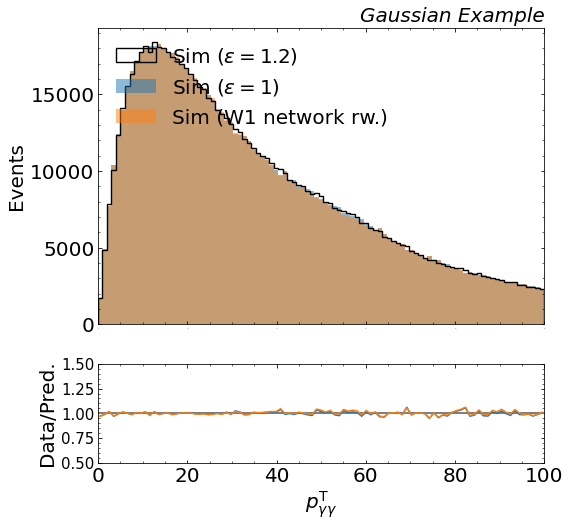

<Figure size 432x288 with 0 Axes>

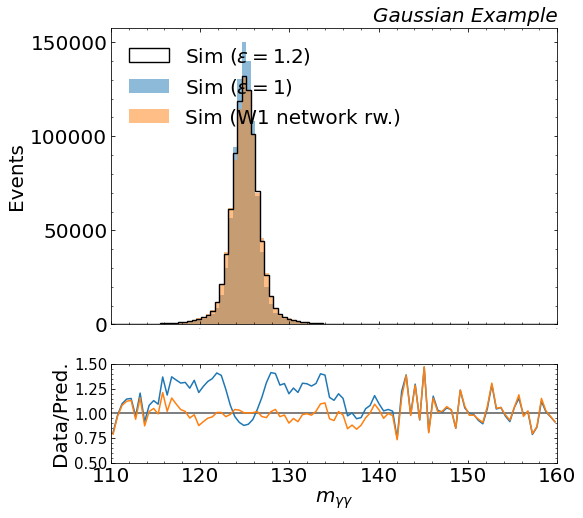

<Figure size 432x288 with 0 Axes>

In [22]:
T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=100000, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1_2(w1_test_dataloader, w1RT_model_network, w1T_model_network, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"$p^\mathrm{T}_{\gamma\gamma}$", density=False)
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"$m_{\gamma\gamma}$", density=False)
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

In [23]:
print(f'model/w1/W1RT_{w1_model_name}.pth')
torch.save(w1RT_model_network, f'model/w1/W1RT_{w1_model_name}.pth')
torch.save(w1T_model_network, f'model/w1/W1T_{w1_model_name}.pth')

model/w1/W1RT_STXS_deltaTheta0.5_2022-12-09.pth


In [11]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1_model_name = f'w1_STXS_noT_deltaTheta0.5_{today}'

w1_model_network = w1_network(sigmoid=True, std_params=std_params, n_inputs=4).double().to(dvc)
optimizer = optim.Adam(w1_model_network.parameters(), lr=0.001)
w1_tr = w1_trainer(w1_dataloader_train, w1_dataloader_test, w1_model_network, loss_fn, optimizer)
# w1_tr.fit()

# torch.save(w1_model_network, f'model/w1/{w1_model_name}.pth')

===================== Model W1 =====================
w1_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=4, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)


In [46]:
# Test the trained W1 model

for i in range(100):
    w1_tr.fit(n_epoch=1)
    w1_model_network_0 = w1_model_network



    T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
    T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

    R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
    R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

    R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
    R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

    R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
    R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

    # print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

    today = str(datetime.date.today())

    w1_test_ds = w0_dataset(T_test_0, R_test_0)
    w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

    Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
    # Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, 0)
    Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

    cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"$p^\mathrm{T}_{\gamma\gamma}$", density=True)
    cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
    cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
    cpwr.add_data(Rs_0[:,0], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
    cpwr.show()

    cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"$m_{\gamma\gamma}$", density=True)
    cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
    cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
    cpwr.add_data(Rs_0[:,1], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
    cpwr.show()

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f8cbb6db898>>
Traceback (most recent call last):
  File "/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):


RuntimeError: DataLoader worker (pid(s) 26284) exited unexpectedly

In [12]:
w1_tr.fit()

[Epoch   1] [Train_loss: 0.693189 Train_auc: 0.501098] [Val_loss: 0.693240 Val_auc: 0.499192]
[Epoch   2] [Train_loss: 0.693149 Train_auc: 0.500819] [Val_loss: 0.693160 Val_auc: 0.499563]
[Epoch   3] [Train_loss: 0.693144 Train_auc: 0.501366] [Val_loss: 0.693159 Val_auc: 0.500229]
[Epoch   4] [Train_loss: 0.693135 Train_auc: 0.502062] [Val_loss: 0.693159 Val_auc: 0.500162]
[Epoch   5] [Train_loss: 0.693132 Train_auc: 0.502707] [Val_loss: 0.693155 Val_auc: 0.499877]
[Epoch   6] [Train_loss: 0.693131 Train_auc: 0.503017] [Val_loss: 0.693164 Val_auc: 0.499850]
[Epoch   7] [Train_loss: 0.693128 Train_auc: 0.503313] [Val_loss: 0.693158 Val_auc: 0.500057]
[Epoch   8] [Train_loss: 0.693127 Train_auc: 0.503491] [Val_loss: 0.693156 Val_auc: 0.499969]
[Epoch   9] [Train_loss: 0.693127 Train_auc: 0.503553] [Val_loss: 0.693163 Val_auc: 0.500223]
[Epoch  10] [Train_loss: 0.693128 Train_auc: 0.503731] [Val_loss: 0.693155 Val_auc: 0.499987]
[Epoch  11] [Train_loss: 0.693127 Train_auc: 0.503823] [Val_

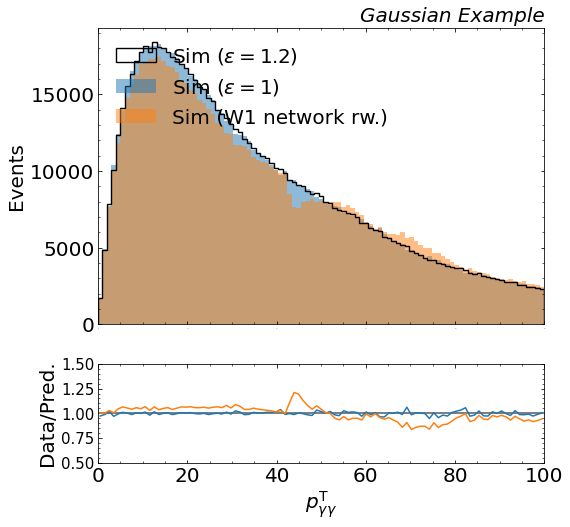

<Figure size 432x288 with 0 Axes>

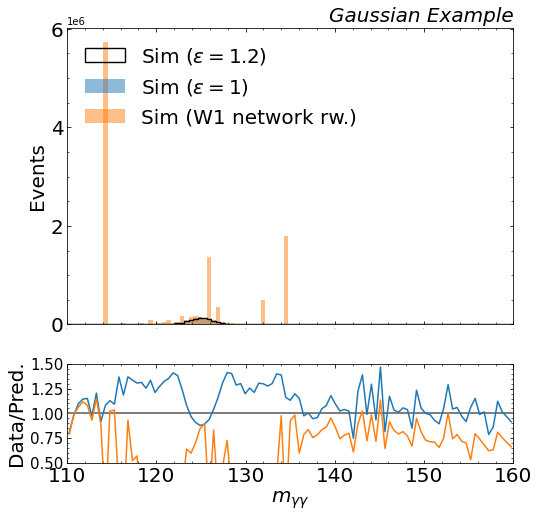

<Figure size 432x288 with 0 Axes>

In [13]:
w1_model_network_0 = w1_model_network

T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
# Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, 0)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"$p^\mathrm{T}_{\gamma\gamma}$", density=False)
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"$m_{\gamma\gamma}$", density=False)
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

Text(0, 0.5, 'Score')

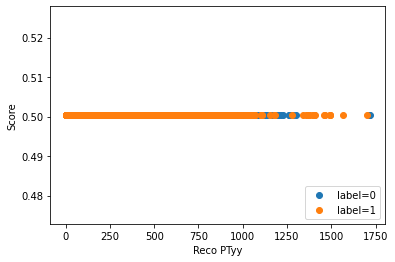

In [93]:
plt.scatter(Rs[:,0][labels==0],logits[labels==0], label="label=0")
plt.scatter(Rs[:,0][labels==1],logits[labels==1], label="label=1")
plt.legend(loc='lower right')
plt.xlabel("Reco PTyy")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

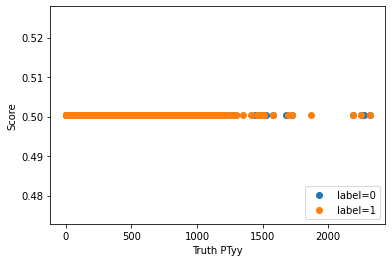

In [94]:
plt.scatter(T0s[labels==0],logits[labels==0], label="label=0")
plt.scatter(T0s[labels==1],logits[labels==1], label="label=1")
plt.legend(loc='lower right')
plt.xlabel("Truth PTyy")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

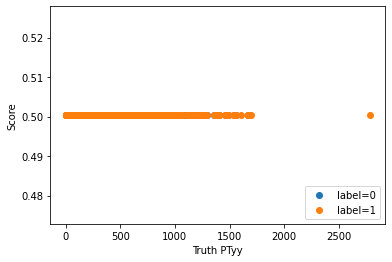

In [95]:
plt.scatter(T1s[labels==0],logits[labels==0], label="label=0")
plt.scatter(T1s[labels==1],logits[labels==1], label="label=1")
plt.legend(loc='lower right')
plt.xlabel("Truth PTyy")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

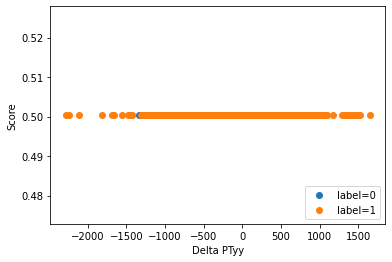

In [96]:
plt.scatter(Rs[:,0][labels==0]-T0s[:,0][labels==0],logits[labels==0], label="label=0")
plt.scatter(Rs[:,0][labels==1]-T0s[:,0][labels==1],logits[labels==1], label="label=1")
plt.legend(loc='lower right')
plt.xlabel("Delta PTyy")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

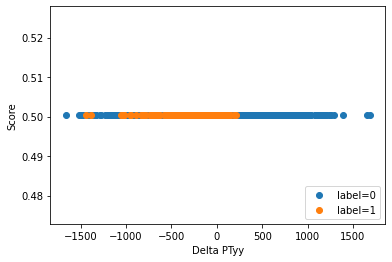

In [97]:
plt.scatter(Rs[:,0][labels==0]-T1s[:,0][labels==0],logits[labels==0], label="label=0")
plt.scatter(Rs[:,0][labels==1]-T1s[:,0][labels==1],logits[labels==1], label="label=1")
plt.legend(loc='lower right')
plt.xlabel("Delta PTyy")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

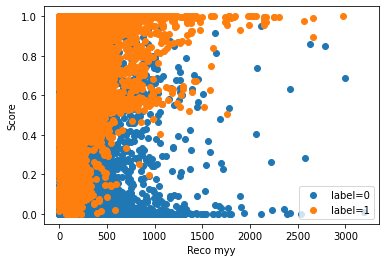

In [51]:
plt.scatter(Rs[:,1][labels==0],logits[labels==0], label="label=0")
plt.scatter(Rs[:,1][labels==1],logits[labels==1], label="label=1")
plt.legend(loc='lower right')
plt.xlabel("Reco myy")
plt.ylabel("Score")

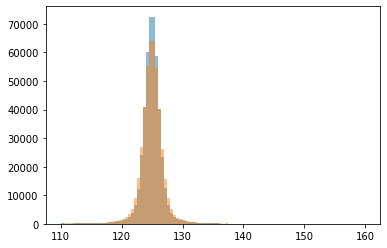

In [50]:
plt.hist(Rs[:,1][labels==0], range=(110, 160), density=False, bins=100, label="Variation", alpha=0.5);
plt.hist(Rs[:,1][labels==1], range=(110, 160), density=False, bins=100, label="Variation", alpha=0.5);

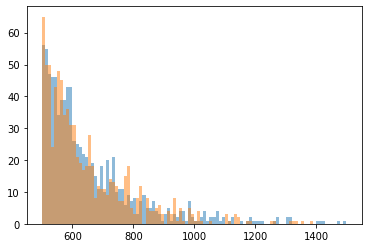

In [47]:
plt.hist(Rs[:,0][labels==0], range=(500, 1500), density=False, bins=100, label="Variation", alpha=0.5);
plt.hist(Rs[:,0][labels==1], range=(500, 1500), density=False, bins=100, label="Variation", alpha=0.5);

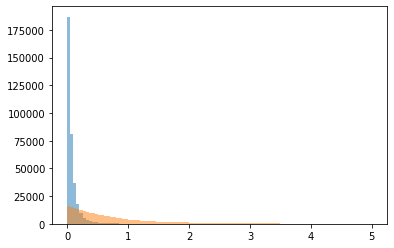

In [84]:
plt.hist((Rs[:,0][labels==0]-52.9940)/60.6173-(T0s[:,0][labels==0]-56.1426)/65.9982, range=(0, 5), density=False, bins=100, label="Variation", alpha=0.5);
plt.hist((Rs[:,0][labels==1]-52.9940)/60.6173-(T0s[:,0][labels==1]-56.1426)/65.9982, range=(0, 5), density=False, bins=100, label="Variation", alpha=0.5);

# plt.hist(Rs[:,0][labels==0]-T0s[:,0][labels==0], range=(0, 1500), density=False, bins=100, label="Variation", alpha=0.5);
# plt.hist(Rs[:,0][labels==1]-T0s[:,0][labels==1], range=(0, 1500), density=False, bins=100, label="Variation", alpha=0.5);

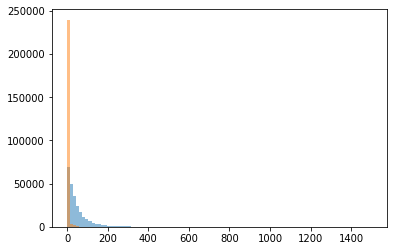

In [64]:
plt.hist(Rs[:,0][labels==0]-T1s[:,0][labels==0], range=(0, 1500), density=False, bins=100, label="Variation", alpha=0.5);
plt.hist(Rs[:,0][labels==1]-T1s[:,0][labels==1], range=(0, 1500), density=False, bins=100, label="Variation", alpha=0.5);

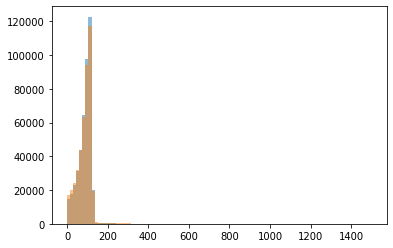

In [65]:
plt.hist(Rs[:,1][labels==0]-T0s[:,0][labels==0], range=(0, 1500), density=False, bins=100, label="Variation", alpha=0.5);
plt.hist(Rs[:,1][labels==1]-T0s[:,0][labels==1], range=(0, 1500), density=False, bins=100, label="Variation", alpha=0.5);

In [67]:
print(np.exp(0.09), np.exp(0.092))

1.0941742837052104 1.0963648220808169


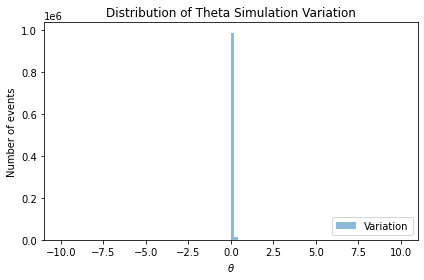

In [16]:
plt.hist(testttt_R, range=(-10, 10), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

# for batch, (R, T0, T1, theta0, theta1, label) in enumerate(w1_dataloader_train):
#     R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

#     R = (R-std_params[2])/std_params[3]
#     plt.hist(R.cpu(), range=(-10, 10), density=False, bins=100, label="Variation", alpha=0.5)
#     plt.xlabel(r'$\theta$')
#     plt.ylabel('Number of events')
#     plt.title(r'Distribution of Theta Simulation Variation')
#     plt.legend(loc='lower right')#, framealpha=0)
#     plt.tight_layout()
#     plt.show()
#     break

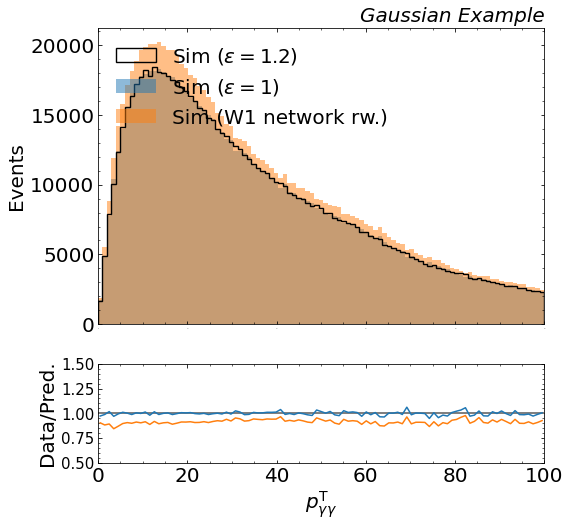

<Figure size 432x288 with 0 Axes>

In [17]:
# Test the trained W1 model

w1_model_name_0 = 'w1_STXS_pTyy_deltaTheta0.5_2022-12-03'

w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)



T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

R_test_0 = R_Ptyy_test_0
R_test_1 = R_Ptyy_test_1

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

# Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, 0)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"$p^\mathrm{T}_{\gamma\gamma}$", density=False, save_name=f"Compare_STXS_Ptyy_forW1network_{today}")
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

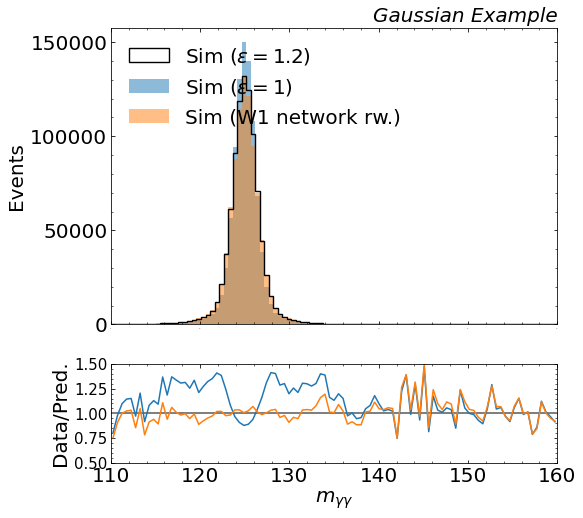

<Figure size 432x288 with 0 Axes>

In [14]:
# Test the trained W1 model

w1_model_name_0 = 'w1_STXS_myy_deltaTheta0.5_2022-12-05'

w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)



T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

R_test_0 = R_myy_test_0
R_test_1 = R_myy_test_1

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
# Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, 0)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"$m_{\gamma\gamma}$", density=False, save_name=f"Compare_STXS_Ptyy_forW1network_{today}")
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

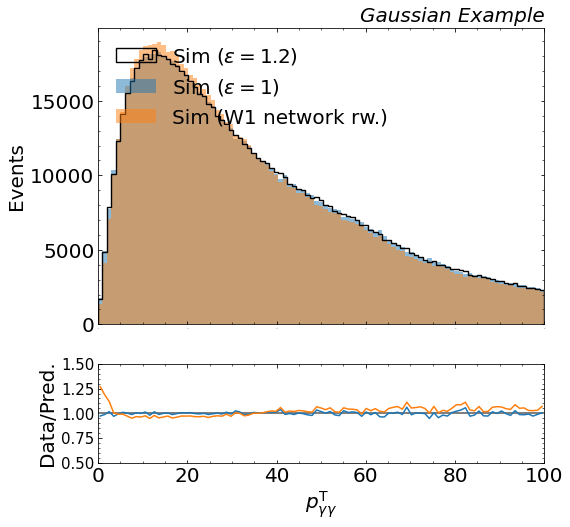

<Figure size 432x288 with 0 Axes>

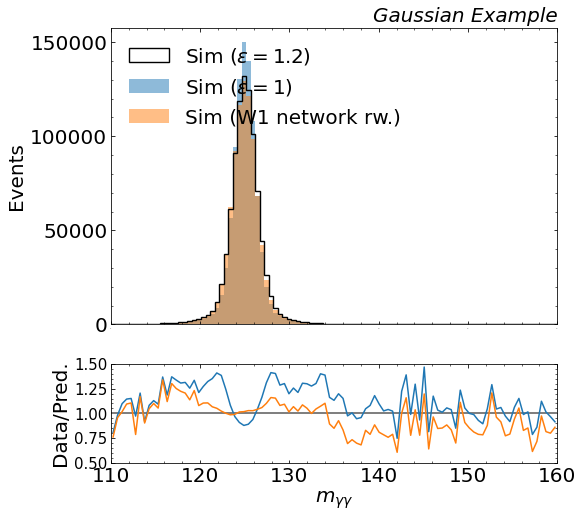

<Figure size 432x288 with 0 Axes>

In [14]:
# Test the trained W1 model

w1_model_name_0 = 'w1_STXS_noTheta_deltaTheta0.5_2022-12-05'

w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)



T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)
        
R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
# Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, 0)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"$p^\mathrm{T}_{\gamma\gamma}$", density=False, save_name=f"Compare_STXS_Ptyy_forW1network_{today}")
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"$m_{\gamma\gamma}$", density=False, save_name=f"Compare_STXS_myy_forW1network_{today}")
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

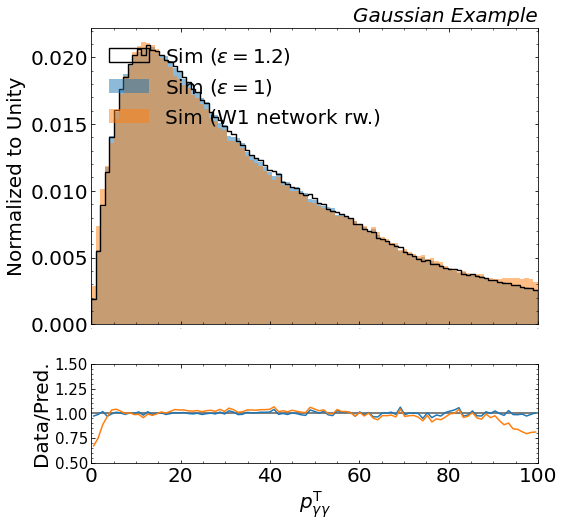

<Figure size 432x288 with 0 Axes>

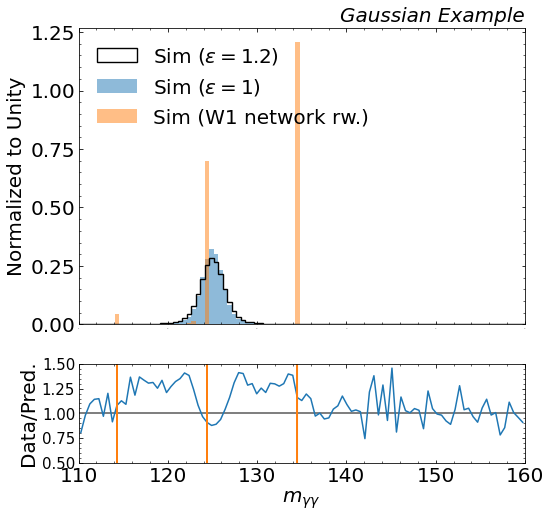

<Figure size 432x288 with 0 Axes>

In [28]:
# Test the trained W1 model

# w1_model_name_0 = 'w1_STXS_deltaTheta0.5_2022-12-05'

# w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)
w1_model_network_0 = w1_model_network



T_test_0 = pythia_0["T_Ptyy"].astype(float).reshape(-1, 1)
T_test_1 = pythia_1["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_test_0 = pythia_0["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_test_1 = pythia_1["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_test_0 = pythia_0["R_myy"].astype(float).reshape(-1, 1)
R_myy_test_1 = pythia_1["R_myy"].astype(float).reshape(-1, 1)

R_test_0 = np.concatenate([R_Ptyy_test_0, R_myy_test_0], axis=1)
R_test_1 = np.concatenate([R_Ptyy_test_1, R_myy_test_1], axis=1)

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test_0, R_test_0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, theta_test)
# Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_network_0, 0)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"$p^\mathrm{T}_{\gamma\gamma}$", density=True, save_name=f"Compare_STXS_Ptyy_forW1network_{today}")
cpwr.add_data(R_Ptyy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 160, 100, xlabel=r"$m_{\gamma\gamma}$", density=True, save_name=f"Compare_STXS_myy_forW1network_{today}")
cpwr.add_data(R_myy_test_1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,1], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,1], weights=W1s_0[:,0], label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

['T_Ptyy', 'R_Ptyy', 'R_myy']


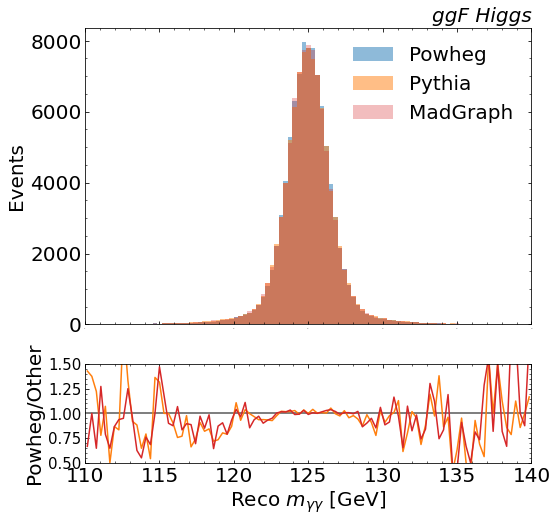

<Figure size 432x288 with 0 Axes>

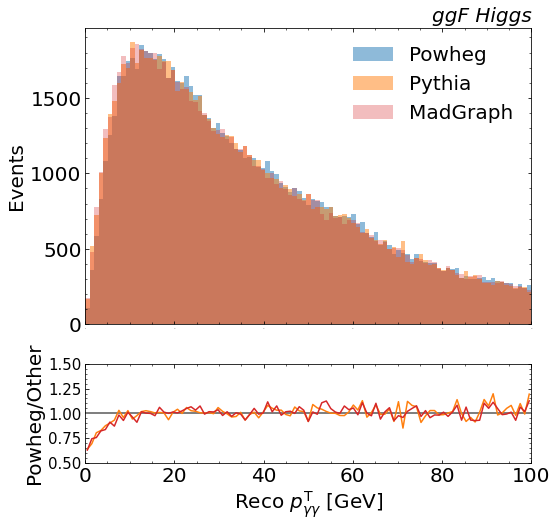

<Figure size 432x288 with 0 Axes>

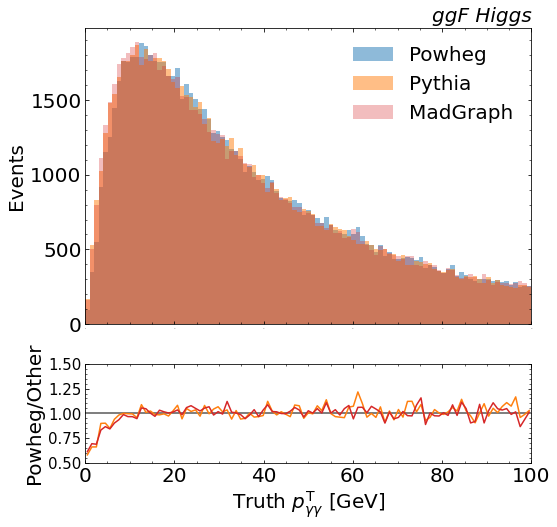

<Figure size 432x288 with 0 Axes>

In [9]:
powheg = np.load("data/processed_powheg.npz")
pythia = np.load("data/processed_pythia.npz")
madgraph = np.load("data/processed_madgraph.npz")

print(list(powheg.keys()))
# print(type(powheg["R_myy"]))
# print(powheg["R_myy"].astype(float)[:20])
# print(pythia["R_myy"].astype(float)[:20])

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r'Reco $m_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(powheg["R_myy"].astype(float), label="Powheg", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia["R_myy"].astype(float), label="Pythia", alpha=0.5, color='tab:orange')
cpwr.add_data(madgraph["R_myy"].astype(float), label="MadGraph", alpha=0.3, color='tab:red')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(powheg["R_Ptyy"].astype(float), label="Powheg", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia["R_Ptyy"].astype(float), label="Pythia", alpha=0.5, color='tab:orange')
cpwr.add_data(madgraph["R_Ptyy"].astype(float), label="MadGraph", alpha=0.3, color='tab:red')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r'Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]', density=False, ratio_label="Powheg/Other", legend_corner="upper right", header="ggF Higgs")#, save_name=f"Compare_R_forW1network_{today}")
cpwr.add_data(powheg["T_Ptyy"].astype(float), label="Powheg", alpha=0.5, color='tab:blue', target=True)
cpwr.add_data(pythia["T_Ptyy"].astype(float), label="Pythia", alpha=0.5, color='tab:orange')
cpwr.add_data(madgraph["T_Ptyy"].astype(float), label="MadGraph", alpha=0.3, color='tab:red')
cpwr.show()

In [8]:
# Load W1 model and convert data into W0 datasets and data loaders

T_sim = pythia["T_Ptyy"].astype(float).reshape(-1, 1)
T_data = powheg["T_Ptyy"].astype(float).reshape(-1, 1)

R_Ptyy_sim = pythia["R_Ptyy"].astype(float).reshape(-1, 1)
R_Ptyy_data = powheg["R_Ptyy"].astype(float).reshape(-1, 1)

R_myy_sim = pythia["R_myy"].astype(float).reshape(-1, 1)
R_myy_data = powheg["R_myy"].astype(float).reshape(-1, 1)

R_sim = np.concatenate([R_Ptyy_sim, R_myy_sim], axis=1)
R_data = np.concatenate([R_Ptyy_data, R_myy_data], axis=1)

# print(T_sim.shape, T_data.shape, R_sim.shape, R_data.shape)

w0_ds = w0_dataset(T_sim, R_sim)
# std_params = [
#     T_sim.mean(),
#     T_sim.std(),
#     R_Ptyy_sim.mean(),
#     R_Ptyy_sim.std()
# ]
std_params = [
    T_sim.mean(),
    T_sim.std(),
    torch.from_numpy(R_sim.mean(axis=0)).to(dvc),
    torch.from_numpy(R_sim.std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

# w1_model_name = 'w1_doubleGaussian_sigma1epsilon1deltaEpsilon0.8_2022-11-04'
# w1_model_network = torch.load(f'model/w1/{w1_model_name}.pth')
w1_model_network = w1_dummy().to(dvc)

loss_fn = NLLLoss_2D(R_data, np.linspace(0,100,101), np.linspace(120,130,6), device=dvc)
# loss_fn = NLLLoss(R_data, np.linspace(0,100,101), normalize=False, device=dvc)

[56.25694203053001, 65.24890312505254, tensor([ 53.1262, 124.1630], device='cuda:0', dtype=torch.float64), tensor([60.1305, 44.1685], device='cuda:0', dtype=torch.float64)]
[[  2  21  47  14   4]
 [ 13  69 165  74   9]
 [ 18 126 281 116   7]
 [ 18 168 396 164  22]
 [ 20 224 535 212  35]
 [ 36 240 622 245  27]
 [ 41 296 669 254  40]
 [ 44 311 862 303  29]
 [ 43 329 828 315  31]
 [ 53 332 887 322  36]
 [ 45 356 921 285  41]
 [ 34 329 890 305  39]
 [ 56 350 934 369  40]
 [ 52 348 892 326  52]
 [ 44 351 924 328  46]
 [ 39 344 885 337  51]
 [ 47 350 879 353  36]
 [ 50 351 869 326  41]
 [ 49 300 854 301  39]
 [ 43 326 829 331  37]
 [ 51 320 801 274  37]
 [ 47 297 825 318  43]
 [ 37 295 805 312  37]
 [ 42 290 807 297  37]
 [ 40 284 750 282  45]
 [ 34 294 727 285  36]
 [ 34 293 727 266  31]
 [ 38 253 668 249  37]
 [ 41 250 681 225  35]
 [ 23 244 656 258  32]
 [ 29 236 605 234  33]
 [ 30 236 609 231  38]
 [ 22 216 580 235  27]
 [ 28 233 531 218  30]
 [ 23 213 559 192  28]
 [ 46 211 506 214  21]

In [9]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
# w0_model_name = f'w0_doubleGaussian_mu0.2epsilon1.2_20bins_Lr0p0095_with_theta_initial0_{w1_model_name}_{today}'
# theta_model_name = f'theta_initial0_doubleGaussian_mu0.2epsilon1.2_20bins_Lr0p0005_with_w0_{w1_model_name}_{today}'

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
# ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

train_w0(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1_model_network, theta_model, loss_fn, optimizer)#, optimizer1=optimizer_1)
# torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
# torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1 =====================
w1_dummy()
Initial theta: 0.0
 Start optimizing the W0 model and theta
[Epoch   0] [Train_loss: -336654.836838] [Val_loss: -335773.994486] [Theta: 0.0]
[Epoch   1] [Train_loss: -360425.284024] [Val_loss: -360377.305261] [Theta: 0.0]
[Epoch   2] [Train_loss: -357795.401461] [Val_loss: -357923.178330] [Theta: 0.0]
[Epoch   3] [Train_loss: -351897.106947] [Val_loss: -352069.075049] [Theta: 0.0]
[Epoch   4] [Train_loss: -350194.343400] [Val_loss: -350375.145819] [Theta: 0.0]
[Epoch   5] [Train_loss: -352573.503

[Epoch  93] [Train_loss: -364295.105103] [Val_loss: -364303.356177] [Theta: 0.0]
[Epoch  94] [Train_loss: -364321.146947] [Val_loss: -364329.371210] [Theta: 0.0]
[Epoch  95] [Train_loss: -364341.652858] [Val_loss: -364352.129787] [Theta: 0.0]
[Epoch  96] [Train_loss: -364362.780970] [Val_loss: -364371.005691] [Theta: 0.0]
[Epoch  97] [Train_loss: -364376.673165] [Val_loss: -364380.501269] [Theta: 0.0]
[Epoch  98] [Train_loss: -364389.459163] [Val_loss: -364397.046066] [Theta: 0.0]
[Epoch  99] [Train_loss: -364394.523366] [Val_loss: -364402.804847] [Theta: 0.0]
[Epoch 100] [Train_loss: -364400.675398] [Val_loss: -364405.121268] [Theta: 0.0]
[Epoch 101] [Train_loss: -364405.325629] [Val_loss: -364408.918592] [Theta: 0.0]
[Epoch 102] [Train_loss: -364408.613737] [Val_loss: -364413.768792] [Theta: 0.0]
[Epoch 103] [Train_loss: -364413.111252] [Val_loss: -364415.269560] [Theta: 0.0]
[Epoch 104] [Train_loss: -364415.677852] [Val_loss: -364415.875967] [Theta: 0.0]
[Epoch 105] [Train_loss: -36

[Test_loss: -364423.007232]


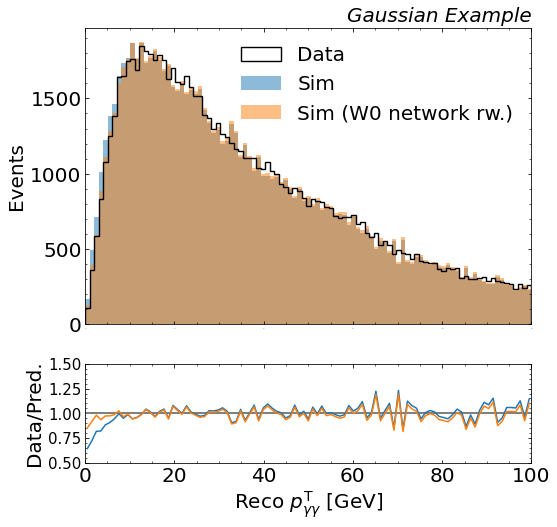

<Figure size 432x288 with 0 Axes>

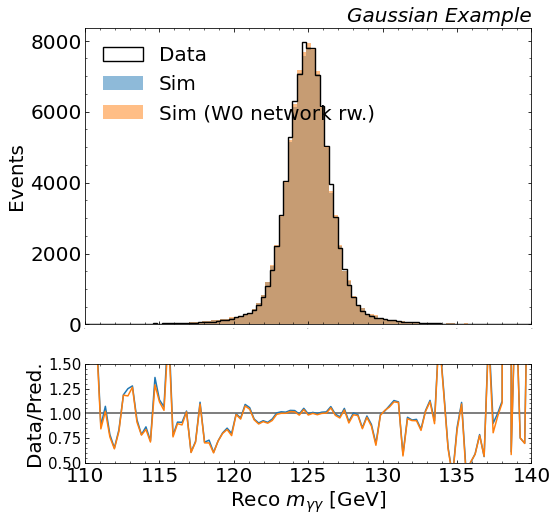

<Figure size 432x288 with 0 Axes>

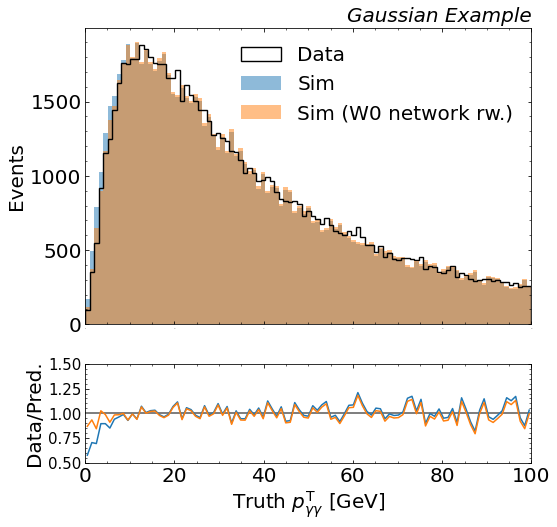

<Figure size 432x288 with 0 Axes>

In [10]:
# Test the trained W0 model and fitted theta value

w0_model_network_0 = w0_model_network
# theta = torch.tensor(2.5)
# w0_model_name_0 = 'w0_v1_epsilon0.2_mu0.8sigma1.5_20bins_sigmoid_2022-10-07'
# w0_model_name_1 = 'w0_v1_mu0.8sigma1.5_20bins_sigmoid_2022-09-29'
# w0_model_name_2 = 'w0_v1_mu0.8sigma1.5_20bins_Lr0p0001_2022-10-07'
# w0_model_name_3 = 'w0_v1_mu0.8sigma1.5_20bins_sigmoid_Lr0p0001_2022-10-07'
# w0_model_name_0 = 'w0_v1_20bins_2022-09-29'
# w0_model_name_1 = 'w0_v1_5bins_2022-09-29'
# w0_model_name_2 = 'w0_v1_20bins_sigmoid_2022-09-29'
# w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')
# w0_model_network_1 = torch.load(f'model/w0/{w0_model_name_1}.pth')
# w0_model_network_2 = torch.load(f'model/w0/{w0_model_name_2}.pth')
# w0_model_network_3 = torch.load(f'model/w0/{w0_model_name_3}.pth')

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_network, theta_model, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy()
# Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()


# Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_analytic, theta_model, loss_fn)
# Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

# Ts_1, Rs_1, Ws_1, W0s_1, W1s_1 = test_w0(w0_dataloader_test, w0_model_network_1, w1_model_analytic, theta, loss_fn)
# Ts_1, Rs_1, Ws_1, W0s_1, W1s_1 = Ts_1.cpu().numpy(), Rs_1.cpu().numpy(), Ws_1.cpu().numpy(), W0s_1.cpu().numpy(), W1s_1.cpu().numpy()

# Ts_2, Rs_2, Ws_2, W0s_2, W1s_2 = test_w0(w0_dataloader_test, w0_model_network_2, w1_model_analytic, theta, loss_fn)
# Ts_2, Rs_2, Ws_2, W0s_2, W1s_2 = Ts_2.cpu().numpy(), Rs_2.cpu().numpy(), Ws_2.cpu().numpy(), W0s_2.cpu().numpy(), W1s_2.cpu().numpy()

# Ts_3, Rs_3, Ws_3, W0s_3, W1s_3 = test_w0(w0_dataloader_test, w0_model_network_3, w1_model_analytic, theta, loss_fn)
# Ts_3, Rs_3, Ws_3, W0s_3, W1s_3 = Ts_3.cpu().numpy(), Rs_3.cpu().numpy(), Ws_3.cpu().numpy(), W0s_3.cpu().numpy(), W1s_3.cpu().numpy()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"Reco $p^\mathrm{T}_{\gamma\gamma}$ [GeV]", density=False, save_name=f"STXS_Compare_R_{today}", legend_corner="upper right")
cpwr.add_data(R_Ptyy_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:, 0], weights=Rs_0[:, 0]*2/Rs_0[:, 0], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:, 0], weights=Ws_0, label="Sim (W0 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(110, 140, 100, xlabel=r"Reco $m_{\gamma\gamma}$ [GeV]", density=False, save_name=f"STXS_Compare_R_{today}")
cpwr.add_data(R_myy_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:, 1], weights=Rs_0[:, 1]*2/Rs_0[:, 1], label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:, 1], weights=Ws_0, label="Sim (W0 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(0, 100, 100, xlabel=r"Truth $p^\mathrm{T}_{\gamma\gamma}$ [GeV]", density=False, save_name=f"STXS_Compare_T_{today}", legend_corner="upper right")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, weights=Ts_0*2/Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (W0 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()